In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim import Adam, lr_scheduler
from Capsule_Layers import *
from CIFAR_Architecture import *
from MNIST_Architecture import *


import matplotlib.pyplot as plt
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms.functional as TransF

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
  del model
except:
  pass

In [4]:
#
# Load dataset.
#
batch_size = 120
test_batch_size = 120
# Normalization for MNIST dataset.
train_transform = transforms.Compose(
                        [transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        ])

test_transform = transforms.Compose(
                        [transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        ])


var_for_input = input('Press 1 for MNIST \n press 2 for CIFAR\n')
var_for_input = int(var_for_input)
if var_for_input == 1:
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
elif var_for_input ==2:
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

Press 1 for MNIST 
 press 2 for CIFAR
1


In [5]:
#Dataloader is a built-in PyTorch module that helps in easy and clean loading of datasets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
if var_for_input == 2:
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                         download=True, transform=test_transform)

  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)

  classes = ('plane', 'car', 'bird', 'cat',
             'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
elif var_for_input == 1:
  testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                         download=True, transform=test_transform)

  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)

  classes = ('0', '1', '2', '3',
             '4', '5', '6', '7', '8', '9')

<function matplotlib.pyplot.show(*args, **kw)>

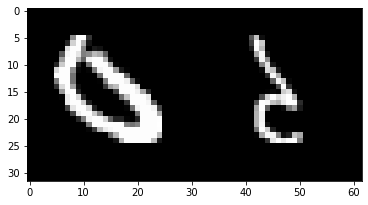

In [7]:

# Images in 2x2 grid
inputs, labels = next(iter(trainloader))
images = torchvision.utils.make_grid(inputs[:2], nrow=2)

images = images.numpy().transpose((1, 2, 0))

plt.imshow(images)
plt.show

In [8]:
inputs, labels = next(iter(testloader))

In [9]:
inputs.shape

torch.Size([120, 1, 28, 28])

In [10]:
class args:
    epochs=50
    debug=0
    save_dir='checkpoints'
    augment='False'
    dataset='mnist'
    layernum=0
    dimcaps=16
    validratio=1
    shift_fraction=0.1
    lr = 0.001
    lr_decay =0.9
    lam_recon=0.0005* inputs.shape[2]*inputs.shape[3]
    use_reconstruction_loss = True
args= args()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
if var_for_input == 1:
  model = Net(inputs.shape,args)
elif var_for_input == 2:
  model = AR_CapsNet_CIFAR(inputs.shape,args)

In [12]:
print(model)

Net(
  (BN1): Conv2d_bn(
    (layer): Sequential(
      (Conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Relu1): ReLU()
    )
  )
  (BN2): Conv2d_bn(
    (layer): Sequential(
      (Conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Relu1): ReLU()
    )
  )
  (Primary_Cap): PrimaryCap()
  (FullyConvCaps): FullyConvCaps()
  (decoder): Decoder(
    (layer): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
  (tanh): Tanh()
)


In [13]:
for name, param in model.named_parameters():
    namae = param.to(device)
    print(name, '\t\t', param.shape)

BN1.layer.Conv1.weight 		 torch.Size([64, 1, 3, 3])
BN1.layer.Conv1.bias 		 torch.Size([64])
BN1.layer.BN1.weight 		 torch.Size([64])
BN1.layer.BN1.bias 		 torch.Size([64])
BN2.layer.Conv1.weight 		 torch.Size([64, 64, 3, 3])
BN2.layer.Conv1.bias 		 torch.Size([64])
BN2.layer.BN1.weight 		 torch.Size([64])
BN2.layer.BN1.bias 		 torch.Size([64])
Primary_Cap.convW_1 		 torch.Size([128, 64, 3, 3])
Primary_Cap.bias_1 		 torch.Size([128])
Primary_Cap.CapsAct_W 		 torch.Size([128, 16, 1, 1])
Primary_Cap.CapsAct_B 		 torch.Size([128])
FullyConvCaps.Att_W 		 torch.Size([80, 8, 16, 1, 1])
FullyConvCaps.ConvTrans_W 		 torch.Size([1280, 16, 14, 14])
FullyConvCaps.ConvTrans_B 		 torch.Size([1280])
FullyConvCaps.CapsAct_W 		 torch.Size([160, 16, 1, 1])
FullyConvCaps.CapsAct_B 		 torch.Size([160])
decoder.layer.0.weight 		 torch.Size([512, 160])
decoder.layer.0.bias 		 torch.Size([512])
decoder.layer.2.weight 		 torch.Size([1024, 512])
decoder.layer.2.bias 		 torch.Size([1024])
decoder.layer.4.weigh

In [14]:
model = model.to(device)

In [15]:
def test(model, test_loader, args):
    model.eval()
    test_loss = 0
    correct = 0
    for x, y in test_loader:
        y = y.type(torch.int64)
        y = torch.zeros(y.size(0), 10).scatter_(1, y.view(-1, 1), 1.)
        x, y = Variable(x.to(device), volatile=True), Variable(y.to(device))
        y_pred = model(x)
        test_loss += model.caps_loss(y, y_pred, x, args.lam_recon).item() * x.size(0)  # sum up batch loss
        y_pred = y_pred.norm(dim=-1)
        y_pred = y_pred.data.max(1)[1]
        y_true = y.data.max(1)[1]
        correct += y_pred.eq(y_true).cpu().sum()

    test_loss /= len(test_loader.dataset)
    return test_loss, int(correct) / int(len(test_loader.dataset))

In [16]:
def train(model, train_loader, test_loader, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param train_loader: torch.utils.data.DataLoader for training data
    :param test_loader: torch.utils.data.DataLoader for test data
    :param args: arguments
    """
    print('Begin Training' + '-'*70)
    from time import time
    import csv
    logfile = open(args.save_dir + '/log.csv', 'w')
    logwriter = csv.DictWriter(logfile, fieldnames=['epoch', 'loss', 'val_loss', 'val_acc'])
    logwriter.writeheader()

    t0 = time()
    optimizer = Adam(model.parameters(), lr=args.lr)
    lr_decay = lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_decay)
    best_val_acc = 0.
    for epoch in range(args.epochs):
        model.train()  # set to training mode
        lr_decay.step()  # decrease the learning rate by multiplying a factor `gamma`
        ti = time()
        training_loss = 0.0
        for i, (x, y) in enumerate(train_loader):  # batch training
            
            y = y.type(torch.int64)
            y = torch.zeros(y.size(0), 10).scatter_(1, y.view(-1, 1), 1.)  # change to one-hot coding
            
            x, y = Variable(x.to(device)), Variable(y.to(device))  # convert input data to GPU Variable


            optimizer.zero_grad()  # set gradients of optimizer to zero
            
            # x, y = Variable(x), Variable(y)
            # x = x.to(device)
            y_pred= model(x)  # forward
            loss = model.caps_loss(y, y_pred, x, args.lam_recon)  # compute loss
            loss.backward()  # backward, compute all gradients of loss w.r.t all Variables
            training_loss += loss.item() * x.size(0)  # record the batch loss
            optimizer.step()  # update the trainable parameters with computed gradients

        # compute validation loss and acc
        val_loss, val_acc = test(model, test_loader, args)
        logwriter.writerow(dict(epoch=epoch, loss=training_loss / len(train_loader.dataset),
                                val_loss=val_loss, val_acc=val_acc))
        print("==> Epoch %02d: loss=%.5f, val_loss=%.5f, val_acc=%.4f, time=%ds"
              % (epoch, training_loss / len(train_loader.dataset),
                 val_loss, val_acc, time() - ti))
        if val_acc > best_val_acc:  # update best validation acc and save model
            best_val_acc = val_acc
            torch.save(model.state_dict(), args.save_dir + '/epoch%d.pkl' % epoch)
            print("best val_acc increased to %.4f" % best_val_acc)
    logfile.close()
    torch.save(model.state_dict(), args.save_dir + '/trained_model.pkl')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)
    print("Total time = %ds" % (time() - t0))
    print('End Training' + '-' * 70)

In [17]:
train(model, trainloader, testloader, args)

Begin Training----------------------------------------------------------------------
==> Epoch 00: loss=0.11323, val_loss=0.04895, val_acc=0.9739, time=36s
best val_acc increased to 0.9739
==> Epoch 01: loss=0.04368, val_loss=0.03862, val_acc=0.9792, time=35s
best val_acc increased to 0.9792
==> Epoch 02: loss=0.03419, val_loss=0.03297, val_acc=0.9827, time=35s
best val_acc increased to 0.9827
==> Epoch 03: loss=0.02917, val_loss=0.03054, val_acc=0.9838, time=35s
best val_acc increased to 0.9838
==> Epoch 04: loss=0.02576, val_loss=0.02713, val_acc=0.9847, time=35s
best val_acc increased to 0.9847
==> Epoch 05: loss=0.02335, val_loss=0.02598, val_acc=0.9856, time=36s
best val_acc increased to 0.9856
==> Epoch 06: loss=0.02124, val_loss=0.02354, val_acc=0.9858, time=35s
best val_acc increased to 0.9858
==> Epoch 07: loss=0.01960, val_loss=0.02314, val_acc=0.9875, time=36s
best val_acc increased to 0.9875
==> Epoch 08: loss=0.01827, val_loss=0.02191, val_acc=0.9881, time=36s
best val_acc